In [1]:
# find path
import os
from pathlib import Path

# import from other folders
# import sys
# sys.path.append('../')
# from helper_functions.find_create_directory import LoadDatasetNeural

# cnn model
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
# from keras.utils import to_categorical

In [2]:
Path().absolute()

PosixPath('/Users/pantelistzamalis/Desktop/python/deep-learning/human-activity-recognition-with-CNNs-notebook')

In [3]:
class LoadDatasetNeural:
    def __init__(self, filepath):
        self.filepath = filepath

    # load a single file as a numpy array
    def load_dataset_nn_file(self):
        datasets_dir = 'datasets'
        curr_dir = Path().absolute()  # current dir
        # filepath = os.path.join(curr_dir.parent, datasets_dir, self.filepath)
        filepath = os.path.join(curr_dir, datasets_dir, self.filepath)
        dataframe = read_csv(filepath, header=None, delim_whitespace=True)
        return dataframe.values

In [4]:
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data_obj = LoadDatasetNeural(prefix + name)
        data = data_obj.load_dataset_nn_file()
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = dstack(loaded)
    return loaded

In [5]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
    # body acceleration
    filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
    # body gyroscope
    filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    load_file = LoadDatasetNeural(prefix + group + '/y_' + group + '.txt')
    y = load_file.load_dataset_nn_file()
    return X, y

In [6]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    print(trainX.shape, trainy.shape)
    print('Unique values in trainy:', np.unique(trainy))
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
    print(testX.shape, testy.shape)
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = keras.utils.to_categorical(trainy)
    print('One hot trainy shape:', trainy.shape)
    testy = keras.utils.to_categorical(testy)
    print('One hot testy shape:', testy.shape)
    return trainX, trainy, testX, testy

In [7]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
Unique values in trainy: [1 2 3 4 5 6]
(2947, 128, 9) (2947, 1)
One hot trainy shape: (7352, 6)
One hot testy shape: (2947, 6)


In [8]:
trainX.shape

(7352, 128, 9)

In [9]:
trainX[0].shape

(128, 9)

In [10]:
trainX[0]

array([[ 1.012817e+00, -1.232167e-01,  1.029341e-01, ...,  3.019122e-02,
         6.601362e-02,  2.285864e-02],
       [ 1.022833e+00, -1.268756e-01,  1.056872e-01, ...,  4.371071e-02,
         4.269897e-02,  1.031572e-02],
       [ 1.022028e+00, -1.240037e-01,  1.021025e-01, ...,  3.568780e-02,
         7.485018e-02,  1.324969e-02],
       ...,
       [ 1.018445e+00, -1.240696e-01,  1.003852e-01, ...,  3.985177e-02,
         1.909445e-03, -2.170124e-03],
       [ 1.019372e+00, -1.227451e-01,  9.987355e-02, ...,  3.744932e-02,
        -7.982483e-05, -5.642633e-03],
       [ 1.021171e+00, -1.213260e-01,  9.498741e-02, ...,  2.881781e-02,
        -3.771800e-05, -1.446006e-03]])

In [11]:
df = pd.DataFrame(data=trainX[0])

In [12]:
trainy[0]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

In [13]:
df.head()

,0,1,2,3,4,5,6,7,8
0,1.012817,-0.123217,0.102934,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859
1,1.022833,-0.126876,0.105687,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316
2,1.022028,-0.124004,0.102102,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250
3,1.017877,-0.124928,0.106553,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751
4,1.023680,-0.125767,0.102814,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553


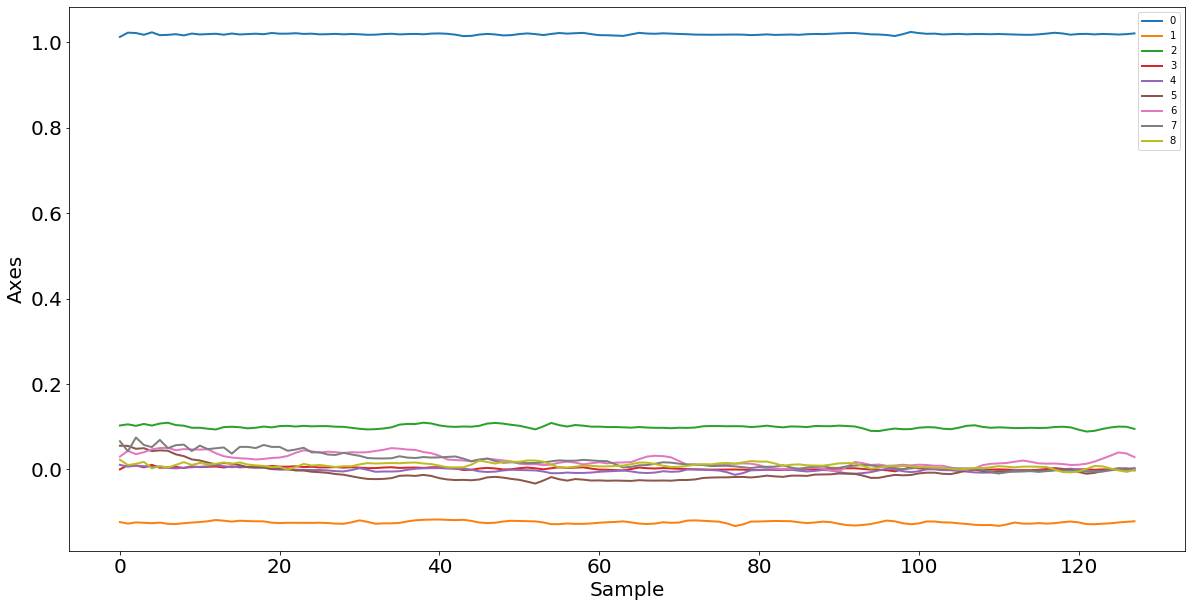

In [14]:
df.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Sample', fontsize=20);
plt.ylabel('Axes', fontsize=20);

In [15]:
# standardize data
def scale_data(trainX, testX, standardize):
    # remove overlap
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # flatten windows
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    # flatten train and test
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    # standardize
    if standardize:
        s = StandardScaler()
        # fit on training data
        s.fit(longX)
        # apply to training and test data
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
    # reshape
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX

In [16]:
trainX_scaled, testX_scaled = scale_data(trainX, testX, standardize=True)

In [17]:
df_scaled = pd.DataFrame(data=trainX_scaled[0])

In [18]:
df_scaled.head()

,0,1,2,3,4,5,6,7,8
0,0.502600,-0.388838,0.046902,0.001567,0.090702,0.533300,0.075566,0.177049,0.089146
1,0.526772,-0.398196,0.054591,0.052748,0.056193,0.529165,0.109285,0.115758,0.039740
2,0.524829,-0.390851,0.044579,0.048313,0.075555,0.465405,0.089275,0.200279,0.051296
3,0.514811,-0.393214,0.057008,0.026676,0.063686,0.478406,0.101033,0.154194,0.069028
4,0.528816,-0.395360,0.046565,0.056200,0.052579,0.414250,0.117730,0.141111,0.009164


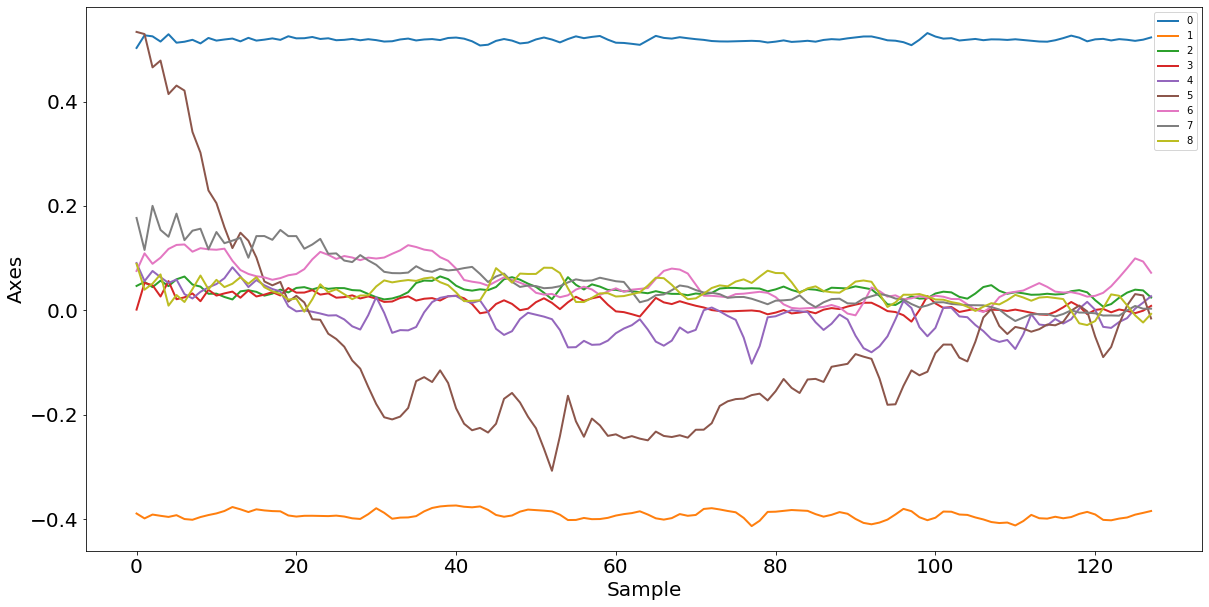

In [19]:
df_scaled.plot(figsize=(20,10), linewidth=2, fontsize=20)
plt.xlabel('Sample', fontsize=20);
plt.ylabel('Axes', fontsize=20);

In [20]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, param):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # scale data
    trainX, testX = scale_data(trainX, testX, param)
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [21]:
# summarize scores
def summarize_results(scores, params):
    print(scores, params)
    # summarize mean and standard deviation
    for i in range(len(scores)):
        m, s = mean(scores[i]), std(scores[i])
        print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # boxplot of scores
    pyplot.boxplot(scores, labels=params)
    pyplot.savefig('exp_cnn_standardize.png')

In [22]:
# run an experiment
def run_experiment(params, repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # test each parameter
    all_scores = list()
    for p in params:
        # repeat experiment
        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%s #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)
    # summarize results
    summarize_results(all_scores, params)

(7352, 128, 9) (7352, 1)
Unique values in trainy: [1 2 3 4 5 6]
(2947, 128, 9) (2947, 1)
One hot trainy shape: (7352, 6)
One hot testy shape: (2947, 6)
>p=False #1: 90.329
>p=False #2: 91.856
>p=False #3: 89.820
>p=False #4: 90.092
>p=False #5: 88.633
>p=False #6: 91.042
>p=False #7: 91.245
>p=False #8: 87.615
>p=False #9: 91.245
>p=False #10: 91.008
>p=True #1: 92.195
>p=True #2: 91.008
>p=True #3: 90.329
>p=True #4: 91.686
>p=True #5: 91.381
>p=True #6: 91.076
>p=True #7: 89.922
>p=True #8: 90.940
>p=True #9: 91.415
>p=True #10: 92.399
[[90.32914638519287, 91.85612201690674, 89.8201584815979, 90.09161591529846, 88.63250613212585, 91.0417377948761, 91.24533534049988, 87.61452436447144, 91.24533534049988, 91.00780487060547], [92.19545125961304, 91.00780487060547, 90.32914638519287, 91.68646335601807, 91.3810670375824, 91.07567071914673, 89.92195725440979, 90.93993902206421, 91.41499996185303, 92.39904880523682]] [False, True]
Param=False: 90.288% (+/-1.246)
Param=True: 91.235% (+/-0.72

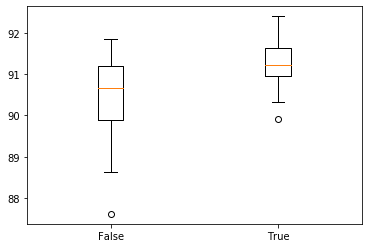

In [23]:
# run the experiment
n_params = [False, True]
run_experiment(n_params)